In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')

df_train_identity = pd.read_csv('../input/train_identity.csv')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity

(590540, 434)


In [4]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)       

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
df_train["P_emaildomain"].isnull().sum()

np.int64(94456)

In [6]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

In [7]:
df_train.isnull().sum().sum()

np.int64(104178894)

In [8]:
df_train.fillna(-999, inplace=True)
df_train.isnull().sum().sum()

np.int64(0)

In [9]:
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12',
       'D13',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=214)
Shape of the cleaned dataframe: (590540, 220)


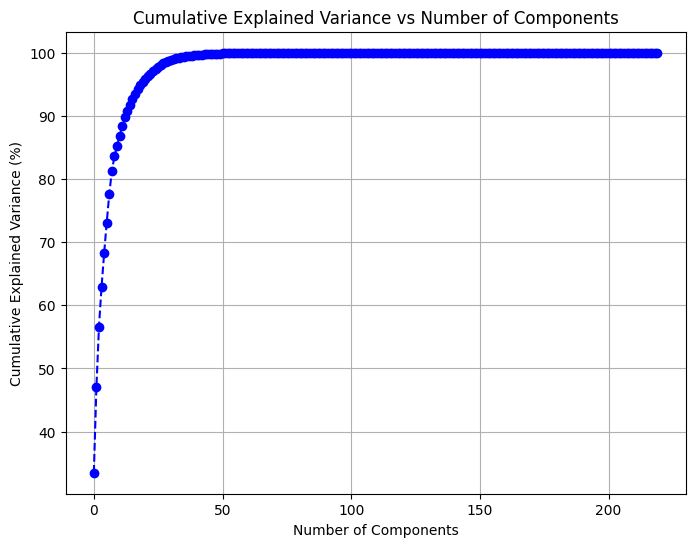

Number of components to retain for 95% explained variance: 27


[np.float64(33.49491606097114),
 np.float64(13.53597442034429),
 np.float64(9.612681139032492),
 np.float64(6.316237006336624),
 np.float64(5.274259378245216),
 np.float64(4.855444086449674),
 np.float64(4.532312573886342),
 np.float64(3.6465300177020774),
 np.float64(2.3022353104064566),
 np.float64(1.6656371736117233),
 np.float64(1.6266899755457194),
 np.float64(1.5877324330695177),
 np.float64(1.364758915291717),
 np.float64(1.020081458271317),
 np.float64(0.9212951831681035),
 np.float64(0.8763090978964782),
 np.float64(0.8527206705567457),
 np.float64(0.7121842103495926),
 np.float64(0.6380129501711422),
 np.float64(0.5198195886301953),
 np.float64(0.4577269088278767),
 np.float64(0.4517425313758515),
 np.float64(0.429579639361378),
 np.float64(0.4113746090559842),
 np.float64(0.3820893228013958),
 np.float64(0.29522082243362013),
 np.float64(0.26704577311650074),
 np.float64(0.24314014935384426),
 np.float64(0.2369208391044301),
 np.float64(0.18435005027447735),
 np.float64(0.12

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_cleaned)

# Compute the covariance matrix
cov_matrix = np.cov(X_scaled.T)  # Transpose to match the correct shape

# Calculate eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and their corresponding eigenvectors
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Total variance
tot = sum(eig_vals)

# Explained variance per component
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]

# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 6))
plt.plot(cum_var_exp, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

# Optionally, decide how many components you want to retain, for example, you might choose 95% explained variance
n_components = np.argmax(cum_var_exp >= 98) + 1  # +1 because of 0-indexing
print(f"Number of components to retain for 95% explained variance: {n_components}")

var_exp


In [13]:
# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'], errors='ignore')
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.88      0.47      0.62      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.74      0.80    118108
weighted avg       0.98      0.98      0.98    118108



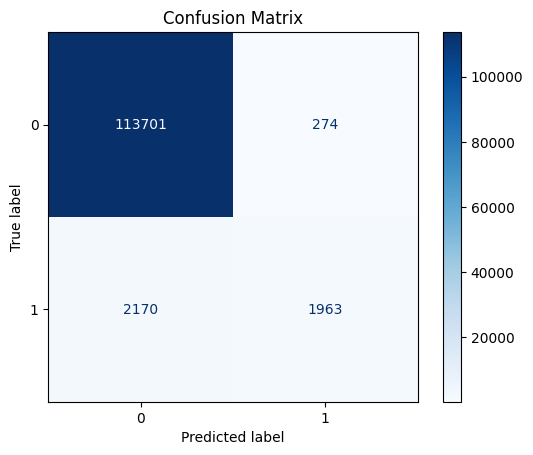

In [16]:
# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=300,
    random_state=42
)
# Train the model on PCA-transformed data
model.fit(X_train_pca, y_train_final)

# Make predictions
y_val_pred = model.predict(X_val_pca)

# Show classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()